In [52]:
from google.colab import drive
drive.mount("/content/drive")
#colab bağlantısı yapıldı

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Veriyi Anlamak
**kalın metin**


In [53]:
#pip install imutils
#veri okuma ve işlemede kullanılacak kütüphaneler
import cv2
import urllib
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

#uyarıları kapatmak için kullanılan
import warnings
warnings.filterwarnings("ignore")

#model değerlendirmede kullanılanlar
from sklearn.metrics import confusion_matrix, classification_report

#model için kullanılacak kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [62]:
#Veri setinin okunması
#veri setini drive'a yükle - adresi kopyala- veri setini okuyacak fonk
dir_path="/content/drive/MyDrive/Colab Notebooks/B200109026/data"

In [63]:
#target size ve label etiket değerlerinin belirlenmesi
target_size= (224, 224) #resmin boyutu
waste_labels= {"0":0, "1":1, "2":2, "3":3, "4":4, "5":5, "6":6, "7":7, "8":8, "9":9, "a":10 , "b":11, "c":12, "d":13, "e":14, "f":15, "g":16, "h":17, "i":18, "j":19, "k":20, "l":21,  "m":22, "n":23, "o":24, "p":25, "q":26, "r":27, "s":28, "t":29, "u":30, "v":31, "w":32, "x":33, "y":34, "z":35} #klasör isimlerini etiket kabul edip encode gerçekleştirdik


In [64]:
def load_datasets(path):
  x=[]
  labels=[]
  #gönderilen paketteki görüntüleri listeleyip sıralama
  image_paths = sorted(list(paths.list_images(path)))
  for image_path in image_paths:
    #belirtilen pathdeki görüntüler openCV ile okunur
    img= cv2.imread(image_path)
    #okunan görüntüler target_size'a göre yeniden ölçeklendirilir
    img=cv2.resize(img, target_size)
    #ölçeklendirilen görüntüler x listesine eklenir
    x.append(img)
    #her path "/" ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil eder
    label=image_path.split(os.path.sep)[-2]
    #waste_tables sözlüğündeki key değerine karşılık gelen valu değeri ile label oluşturulur
    labels.append(waste_labels[label])

  #veri setini random karıştır
  x, labels = shuffle(x,labels, random_state=42)

  #boyut ve sınıf bilgisi raporlama
  print(f"x boyutu:{np.array(x).shape}")
  print(f"label sınıf sayısı:{len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x,labels


In [65]:
x,labels = load_datasets(dir_path)

x boyutu:(2515, 224, 224, 3)
label sınıf sayısı:36 Gözlem sayısı: 2515


In [66]:
 input_shape=(np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)
 print(input_shape)

(224, 224, 3)


In [74]:
def visualize_img(image_batch,label_batch):
  plt.figure(figsize=(10,10))
  for n in range(36):
    ax=plt.subplot(6,6,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=36)[n]==1][0].title())
    plt.axis("off")


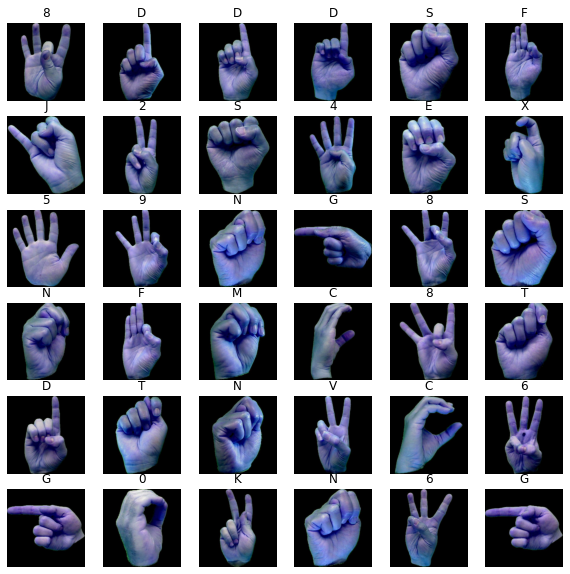

In [75]:
visualize_img(x,labels)

In [76]:
#train için bir generator tanımlıyoruz
train = ImageDataGenerator(horizontal_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)
#test için generator tanımla
test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

In [79]:
train_generator=train.flow_from_directory(directory=dir_path,
                                          target_size=(target_size),
                                          class_mode="categorical",
                                          subset="training")
test_generator=test.flow_from_directory(directory=dir_path,
                                        target_size=(target_size),
                                        batch_size=251,
                                        class_mode="categorical",
                                        subset="validation")

Found 2264 images belonging to 36 classes.
Found 251 images belonging to 36 classes.


In [81]:
#MODELLEME
#CNN modeli kurma basamakları
#Sequential-> sıralı katmanlı sinir ağı kurma nesnesi
#Evrişim katmanı(Conv2D)-> görüntüden özellik çıkarımı
#Havuzlama katmanı (pooling layer)
#Aktivasyon fonksiyonu katmanı
#Flattening katmanı-> veriyi sinir ağının girişine uygun hale getir
#Dense katmanı-> bir katmandan aldığı nöronların bir sonraki katmana girdi olarak bağlanmasını sağler units=nöron sayısı
#Dropout katmanı ->overfitin önüne geçme, rastgele nöron söndürme

In [82]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu"))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation="relu"))
model.add(Dropout(rate=0.2))

model.add(Dense(units=36, activation="softmax"))

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [84]:
#Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

In [85]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(), "acc"]
              )

In [92]:
callbacks= [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"),
            
            ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]

In [93]:
#Modelin eğitilmesi

In [96]:
history=model.fit_generator(generator=train_generator,
                            epochs=100,
                            validation_data=test_generator,
                            callbacks=callbacks,
                            workers=4,
                            steps_per_epoch=2264//32,
                            validation_steps=251//32)

Epoch 1/100
70/70 [==============================] - ETA: 0s - loss: 3.4668 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.0582
Epoch 1: val_loss improved from inf to 3.01332, saving model to mymodel.h5
70/70 [==============================] - 27s 231ms/step - loss: 3.4668 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.0582 - val_loss: 3.0133 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.1554
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 3.0608 - precision: 0.5000 - recall: 0.0116 - acc: 0.1331
Epoch 2: val_loss improved from 3.01332 to 2.25366, saving model to mymodel.h5
70/70 [==============================] - 15s 208ms/step - loss: 3.0608 - precision: 0.5000 - recall: 0.0116 - acc: 0.1331 - val_loss: 2.2537 - val_precision: 0.5833 - val_recall: 0.0279 - val_acc: 0.3108
Epoch 3/100
69/70 [============================>.] - ETA: 0s - loss: 2.7071 - precision: 0.5310 - recall: 0.0350 - acc: 0.2150
Epoch 3: val_loss improved from 2

In [97]:
#Accuracy - Loss Grafikleri

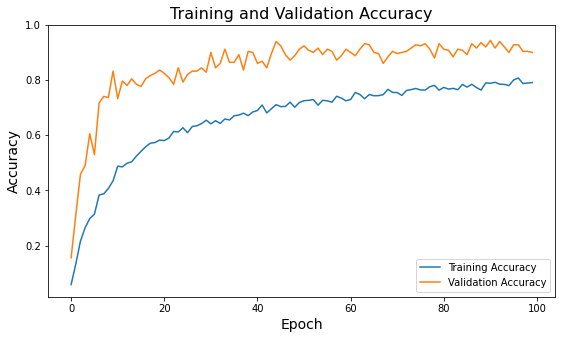

In [100]:
#Accuracy Grafiği
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history["acc"], label="Training Accuracy")
plt.plot(history.history["val_acc"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy", fontsize=16)
plt.show()

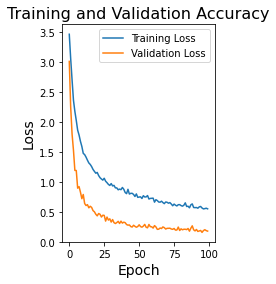

In [101]:
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="uper right")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.ylim([0,max(plt.ylim()),])
plt.title("Training and Validation Accuracy", fontsize=16)
plt.show()